In [30]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
def f(x):
    return 3*x**2 - 4*x + 5

In [32]:
f(3.0)

20.0

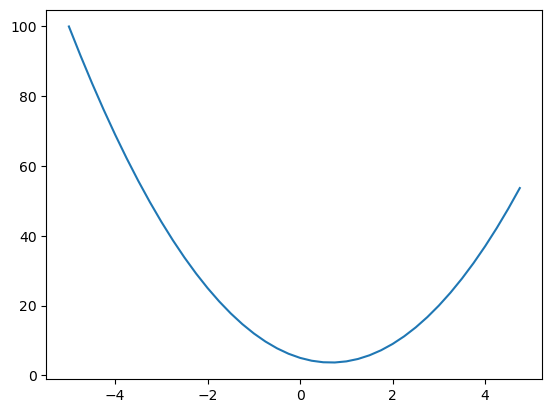

In [33]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys
plt.plot(xs, ys)

In [34]:
h = 0.0001
x = 2/3
(f(x + h) - f(x)) / h

0.0002999999981767587

In [35]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [36]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [37]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out 
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), _op="tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [38]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [39]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # LR left-to-right

    nodes, edges = trace(root)
    print(edges)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ("record") node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}"%(n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [40]:
# BACKPROPAGATION

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
b = Value(6.8813735870195432, label="b")

# (x1 * w1) + (x2 * w2) + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

# activation func
o = n.tanh(); o.label = "o"

{(Value(data=0.8813735870195432), Value(data=0.7071067811865476)), (Value(data=0.0), Value(data=0.0)), (Value(data=0.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=1.0), Value(data=0.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=-6.0), Value(data=-6.0))}


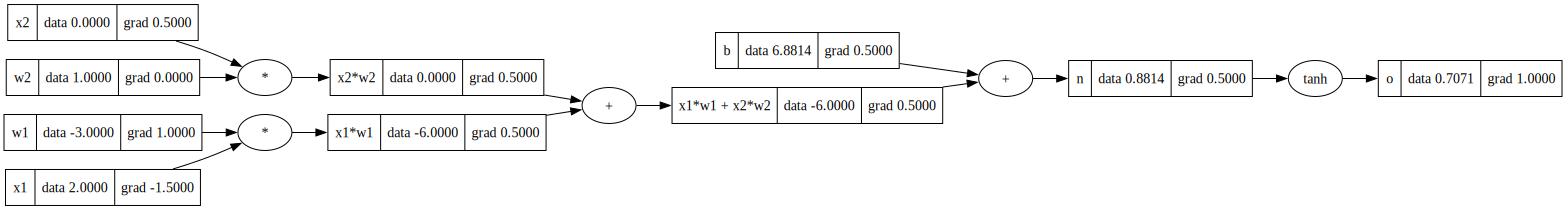

In [41]:
o.backward()
draw_dot(o)

In [42]:
# BACKPROPAGATION

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
b = Value(6.8813735870195432, label="b")

# (x1 * w1) + (x2 * w2) + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

# activation func
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = "o"

{(Value(data=5.828427124746192), Value(data=6.828427124746192)), (Value(data=1), Value(data=6.828427124746192)), (Value(data=0.0), Value(data=0.0)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=1.7627471740390863), Value(data=5.828427124746192)), (Value(data=1.0), Value(data=0.0)), (Value(data=-1), Value(data=4.828427124746192)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=2), Value(data=1.7627471740390863)), (Value(data=5.828427124746192), Value(data=4.828427124746192)), (Value(data=0.1464466094067262), Value(data=0.7071067811865477)), (Value(data=0.0), Value(data=-6.0)), (Value(data=0.8813735870195432), Value(data=1.7627471740390863)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=4.828427124746192), Value(data=0.7071067811865477)), (Value(data=2.0), Value(data=-6.0)), (Value(data=6.828427124746192), Value(data=0.1464466094067262))}


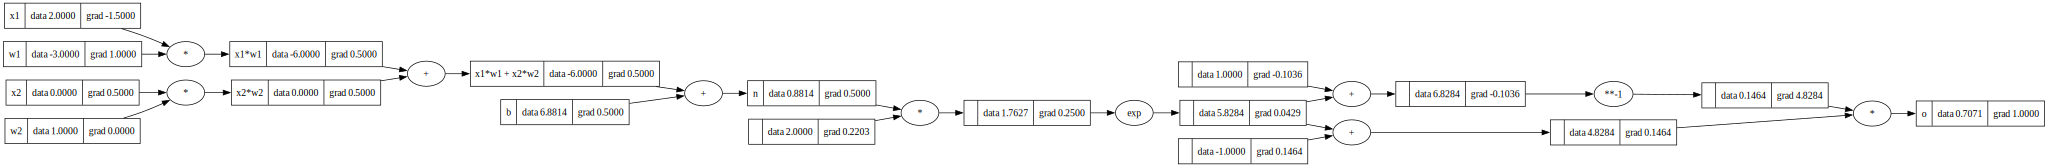

In [43]:
o.backward()
draw_dot(o)

In [44]:
import torch

In [45]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-----")
print("x2: ", x2.grad.item())
print("w2: ", w2.grad.item())
print("x1: ", x1.grad.item())
print("w2: ", w1.grad.item())

0.7071066904050358
-----
x2:  0.5000001283844369
w2:  0.0
x1:  -1.5000003851533106
w2:  1.0000002567688737


Our micrograd works fine! Results are same with PyTorch's results.

In [52]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [100]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.16065656021006067)

In [101]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [102]:
for k in range(200):
    # forward
    y_preds = [n(x) for x in xs] 
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_preds)])

    # zero grad
    for p in n.parameters():
        p.grad = 0.0

    # backward
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 1.9547847738361857
1 0.12690774385732603
2 0.10719853704004469
3 0.0924066173325663
4 0.08094724039417518
5 0.07183942993138182
6 0.06444662819379458
7 0.05833936371896148
8 0.05321826080896992
9 0.04886875770400652
10 0.04513336576569679
11 0.0418940683005895
12 0.03906080758711253
13 0.03656375062436072
14 0.03434796953158711
15 0.03236970528792453
16 0.03059369388392335
17 0.028991220225066457
18 0.027538679923797646
19 0.026216501581003235
20 0.025008328904585816
21 0.023900392770873226
22 0.022881023941501863
23 0.02194027118503129
24 0.021069599260754295
25 0.020261648032010596
26 0.019510038815880915
27 0.018809217557473626
28 0.018154326949779896
29 0.017541101482273176
30 0.016965780784199365
31 0.016425037664827332
32 0.01591591803640583
33 0.015435790502761762
34 0.014982303855209614
35 0.014553351072402174
36 0.014147038697321302
37 0.013761660681510973
38 0.013395675957831223
39 0.013047689138891448
40 0.012716433846804126
41 0.012400758266960894
42 0.012099612588770368


In [103]:
y_preds # looks great!

[Value(data=0.9790960491507967),
 Value(data=-0.9895302467776945),
 Value(data=-0.9706172881633301),
 Value(data=0.9695540817274733)]